# **Which Neighborhood in Pittsburgh is best to find parking in?**

### **By CodeCrafters Collective (Quinn Boquist, Matthew Crigler, and Brandon Kowalski)**

*group name generated by ChatGPT* :)

![ParkingMeter](meterPic.jpg)

## **Introduction**

Everyone has tried to find parking in the city before. Depending on where you are, it might be pretty difficult! Look no further, as we have come up with a way to determine the best neighborhood to park in through analyzing three submetrics: metered spot density, **MATT'S METRIC**, and **BRANDON'S METRIC**. By combining the results of these tests we can determine which neighborhood will be the easiest and cheapest place to find parking. We considered also including popularity as a metric, but then the best neighborhood would vary from time to time, and we are looking for an overall best choice assuming average conditions.

### **Our Combined Metric: Parkability.**
 - Metered Spot Density (metered spots per mile of road)
 - **MATT'S METRIC**
 - Total amount of Transactions in a neighborhood

### **Datasets used on this project:**

Parking Meter Locations (Quinn): https://data.wprdc.org/dataset/pittsburgh-parking-meters-and-payment-points/resource/db139ccd-6753-48ad-b3ff-118fe2223d55

- **Used for locations of all metered spots.**


Transportation Data (Quinn): https://data.wprdc.org/dataset/pgh/resource/5d61b60b-bd25-4c33-8420-e31a9135ec6e

- **Used for total street mileage.**



Zone and Lot Attributes (Matt): https://data.wprdc.org/dataset/zone-and-lot-attributes

- **?**


Meter Transactions (Brandon): https://data.wprdc.org/dataset/parking-transactions/resource/f58a2f59-b2e8-4067-a7d9-bbedb7e119b0

- **?**

## **Metric 1: Metered Spot Density**
### Quinn

This metric provides useful information because the higher the spot density, the faster you can search through spots for an empty one. Additionally, just the number of metered spots in a neighborhood shows the capacity it has for parking.

I first started by importing some important stuff like pandas and this code snippet for turning coordinates into neighborhoods.

In [1]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt

#CODE SNIPPET
NEIGHBORHOODS = geopandas.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip")
ZIPS = geopandas.read_file("https://data.wprdc.org/dataset/1a5135de-cabe-4e23-b5e4-b2b8dd733817/resource/ec228c0e-6b1e-4f44-a335-df05546d52ea/download/alcogisallegheny-county-zip-code-boundaries.zip")
def geo_to_neighborhood(latitude, longitude):
    pt = Point(longitude, latitude)
    for _idx, neighborhood in NEIGHBORHOODS.iterrows():
        if neighborhood["geometry"].contains(pt):
            return neighborhood["hood"]
    return None

Then, I used that function to calculate the total number of metered parking spots for all neighborhoods.

In [2]:
rawcontents=pd.read_csv("ParkingSpotLocations.csv")
meters={}
count=0
avg=0.0
nan=0
num=0
for lat in rawcontents.latitude:                          #counts the parking meters in each neighborhood and adds to a dictionary
    if count%10000==0:                                    #takes a few minutes to run so I added a progress indicator
        print("Progress:", count//10000, "/7")
    lon=rawcontents.longitude[count]
    if type(lat)==type(lon)==type(avg):                   #some coordinates in file were not a number
        hood=geo_to_neighborhood(lat,lon)
        if hood==None:
            num+=1
        else:
            if hood in meters.keys():
                meters[hood]=meters[hood]+1
            else:
                meters[hood]=1
    else:
        nan+=1
    count+=1
print("Non-number coordinates:",nan)
print("Coordinates that aren't in a neighborhood:",num)
meters

<ipython-input-2-e58cdd6f6892>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  rawcontents=pd.read_csv("ParkingSpotLocations.csv")


Progress: 0 /7
Progress: 1 /7
Progress: 2 /7
Progress: 3 /7
Progress: 4 /7
Progress: 5 /7
Progress: 6 /7
Progress: 7 /7
Non-number coordinates: 7550
Coordinates that aren't in a neighborhood: 6797


{'Squirrel Hill South': 3486,
 'Allegheny Center': 2361,
 'North Oakland': 6641,
 'Crawford-Roberts': 565,
 'Central Oakland': 1776,
 'Central Business District': 7172,
 'South Side Flats': 5570,
 'Allegheny West': 1448,
 'Strip District': 3114,
 'Shadyside': 2975,
 'East Allegheny': 734,
 'West Oakland': 888,
 'Central Lawrenceville': 1186,
 'East Liberty': 3583,
 'Mount Washington': 936,
 'Brookline': 1184,
 'Lower Lawrenceville': 935,
 'Carrick': 639,
 'Terrace Village': 717,
 'Knoxville': 322,
 'Greenfield': 198,
 'Bloomfield': 4106,
 'Bluff': 2041,
 'Point Breeze': 244,
 'North Shore': 2151,
 'Squirrel Hill North': 1610,
 'Garfield': 249,
 'Allentown': 269,
 'South Oakland': 417,
 'Duquesne Heights': 216,
 'Upper Hill': 148,
 'Brighton Heights': 50,
 'West End': 387,
 'Beechview': 510,
 'Upper Lawrenceville': 76,
 'Central Northside': 297,
 'Perry North': 172,
 'Friendship': 98,
 'Homewood South': 71}

Now that we know how many parking spots are in each neighborhood, we need to relate this to how much road there is in each neighborhood. I got this information from the transportation dataset.

In [25]:
rawcontents=pd.read_csv("transportation.csv")                   #gets total miles of roads for each neighborhood
roads={}
count=0
for hood in rawcontents.Neighborhood:
    if hood in meters.keys():
        roads[hood]=rawcontents['Total Street Miles'][count]
    count+=1

myKeys = list(meters.keys())                                     #sort by neighborhood name for combining data
myKeys.sort()
sorted_meters = {i: meters[i] for i in myKeys}
myKeys = list(roads.keys())
myKeys.sort()
sorted_roads = {i: roads[i] for i in myKeys}
roadsVals=sorted_roads.values()
frame=pd.DataFrame.from_dict(sorted_meters, orient='index', dtype=None, columns={"Parking Spots"})  #create dataframe
frame['Street Miles']=roadsVals
frame

,Parking Spots,Street Miles
Allegheny Center,2361,4.14
Allegheny West,1448,4.87
Allentown,269,12.33
Beechview,510,30.75
Bloomfield,4106,31.74
Bluff,2041,16.48
Brighton Heights,50,29.52
Brookline,1184,56.88
Carrick,639,45.98
Central Business District,7172,30.84


Final step is to calculate the density of parking spots to scale each neighborhood fairly.

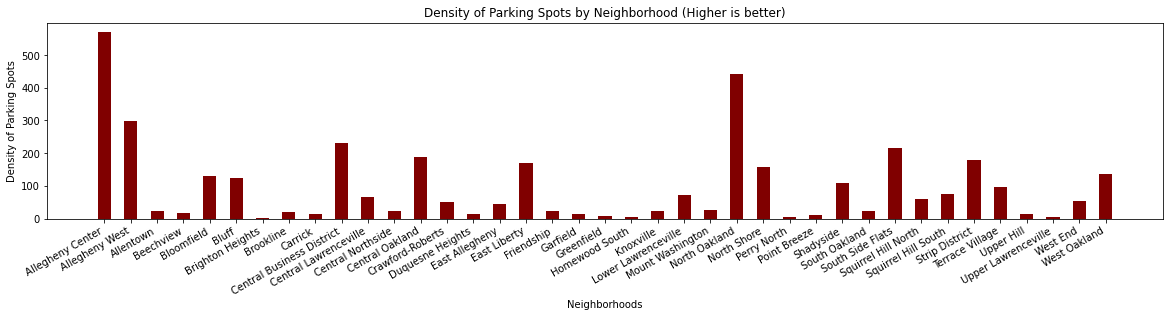

,Parking Spots,Street Miles,Density
Allegheny Center,2361,4.14,570.289855
North Oakland,6641,15.00,442.733333
Allegheny West,1448,4.87,297.330595
Central Business District,7172,30.84,232.555123
South Side Flats,5570,25.94,214.726291
Central Oakland,1776,9.50,186.947368
Strip District,3114,17.34,179.584775
East Liberty,3583,21.13,169.569333
North Shore,2151,13.60,158.161765
West Oakland,888,6.49,136.825886


In [26]:
import matplotlib.pyplot as plt
densities=[]
count=0
for numMeters in frame['Parking Spots']:        #calculates density in Parking Meters per mile of street
    numMiles=frame['Street Miles'][count]
    densities.append(numMeters/numMiles)
    count+=1
frame['Density']=densities

hoods = sorted(meters.keys())
nums = frame['Density']
fig = plt.figure(figsize = (20, 4))
plt.bar(hoods, nums, color ='maroon', width = 0.5)
fig.autofmt_xdate()
plt.xlabel("Neighborhoods")
plt.ylabel("Density of Parking Spots")
plt.title("Density of Parking Spots by Neighborhood (Higher is better)")
plt.show()
frame=frame.sort_values('Density', ascending=False)
frame.head(10)

For my metric, the best was Allegheny Center. Every one of these top 10 have very good densities though.

## **Metric 2: METRIC**
### Brandon

blah blah blah

## **Metric 3: METRIC**
### Matt

blah blah blah

# **Combining the Metrics:**

The way we combined the metrics was to manually select which one scored the highest placements in all categories.

# **Conclusions:**

Quinn:

- My favorite neighborhood is good old South Oakland, but assuming you don't have a specific permit to park there, there are very few metered spots there which caused it to score low on that metric. I overall don't have much to say about this because I am still not too familiar with the many neighborhoods in Pittsburgh. I was still suprised that a neighborhood so downtown was the winner. Based on the data, though, I can trust that Strip District is the best place to park.

Matt:

- blah

Brandon:

- The best neighborhood to park in is South Side, South side has the most total transactions by a large margin which means there must be an abundence of parking spots for the people. Although South Side has the most tranactions, other data has pointed out that South Side has a disadvantage compared to areas like the Strip District. When combining the data from all of our data-sets, I believe that the Strip District is the best neighborhood to park.